#Домашнее задание. Логистическая регрессия.

##Часть 1. Реализация логистической регрессии с регуляризацией

In [ ]:
#first import libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

##Задание 1. Реализация алгоритма логистической регрессии с L2-регуляризацией.

* Метод basic_term(self, X, y, logits) вычисяется по формуле с семинара

$$\nabla_w L = -\frac{1}{\ell}\sum\limits_{i=1}^{\ell}y^i\cdot\left(1 - \frac{1}{1 + \mathrm{exp}(-y^i \cdot \langle w, x^i \rangle)}\right) \cdot x^i = -\frac{1}{\ell}\sum\limits_{i=1}^{\ell}y^i\cdot\left(1 - \sigma(y^i \cdot \langle w, x^i \rangle)\right) \cdot x^i.$$

*Метод regularization_term(self, weights) вычиляет градиент рег.слагаемого функ.потерь. Регуляризационное слагаемое имеет вид
$$L_2 (w) = \sum_{j=1}^{n}w_j^2.$$
Производная по каждому слагаемому:
$$\frac{\partial L_2}{\partial w_1} = 2 \cdot w_1.$$
Градиент по вектору весов:
$$\nabla_{w}L_2 = (0, 2w_1, \ldots, 2w_k) $$

*Метод grad(self, X, y, logits, weights) складывает слагаемые с учетом констнатны регуляризации $C$:
$$\nabla_{w}L + C\cdot \nabla_{w}L_2. $$

In [ ]:
class MyL2LogisticRegression(object):
    def __init__(self, C=1):
        self.coef_ = None
        self.intercept_ = None
        self.C = C
    
    def sigmoid(self, t):
        return 1. / (1 + np.exp(-t))
    
    def basic_term(self, X, y, logits):
        grad = -1. / X.shape[0] * y * (1 - self.sigmoid(y * logits))
        grad = X.T @ grad.reshape(-1, 1)
        return grad.T
    
    def regularization_term(self, weights):
        grad = 2 * weights
        grad[0] = 0
        return grad
    
    def grad(self, X, y, logits, weights):
        fi = self.basic_term(X, y, logits)
        se = self.regularization_term(weights)
        grad = fi + self.C * se
        return grad
    
    def fit(self, X, y, max_iter=1000, lr=0.1):

        X = np.array(X)
        y = np.array(y)
        y = 2 * y - 1

        X = np.hstack([np.ones([X.shape[0], 1]), X])

        l, n = X.shape

        weights = np.random.randn(n)

        losses = []

        for iter_num in range(max_iter):

            logits = (X @ weights.reshape(n, 1)).ravel()
            grad = self.grad(X, y, logits, weights)
            weights -= grad[0] * lr

            loss = np.mean(np.log(1 + np.exp(-y * logits))) + self.C * np.sum(weights[1:] ** 2)
            losses.append(loss)
        
        self.coef_ = weights[1:]
        self.intercept_ = weights[0]

        return losses

    def predict_proba(self, X):

        X = np.array(X)
        X = np.hstack([np.ones([X.shape[0], 1]), X])
        weights = np.concatenate([self.intercept_.reshape([1]), self.coef_])
        logits = (X @ weights.reshape(-1, 1))

        return self.sigmoid(logits)
    
    def predict(self, X, threshold=0.5):
        return self.predict_proba(X) >= threshold

###Тест класса

In [ ]:
dummy_clf = MyL2LogisticRegression(C=10.)
X = np.arange(6).reshape(2, 3)
y = np.array([0, 1])
weights = np.array([-1., 1., 2])
logits = X @ weights

In [ ]:
b_t = dummy_clf.basic_term(X, y, logits)
assert np.allclose(b_t, [-2.50521328e-05, -3.34028437e-05, -4.17535546e-05])

In [ ]:
reg_t = dummy_clf.regularization_term(weights)
assert np.allclose(reg_t, [0., 2., 4.])

In [ ]:
grad = dummy_clf.grad(X, y, logits, weights)
assert np.allclose(grad, [-2.50521328e-05,  1.99999666e+01,  3.99999582e+01])

### Проверка на датасете blobs с семинара

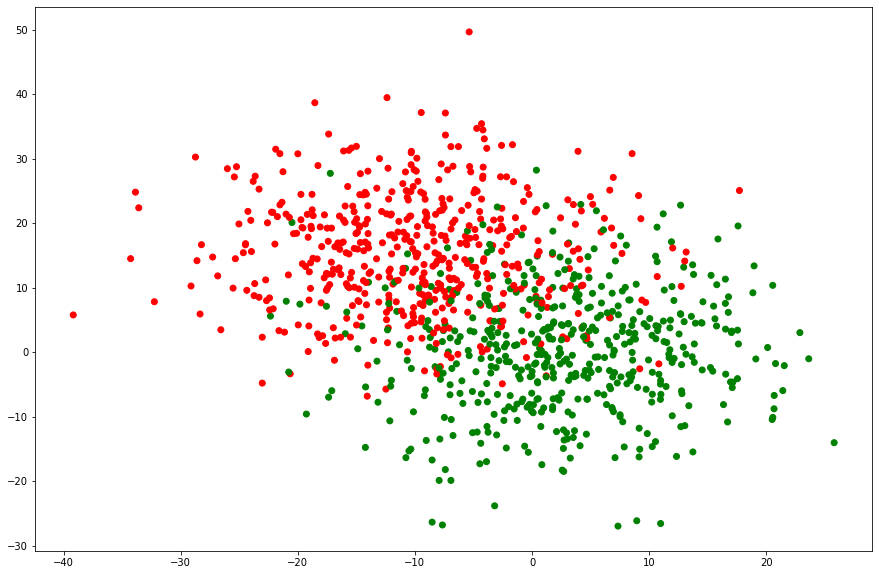

In [ ]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=1000, centers=[[-10, 15], [2, -0.5]], cluster_std=9, random_state=42)


colors = ('red', 'green')
colored_y = np.zeros(y.size, dtype=str)

for i, cl in enumerate([0, 1]):
    colored_y[y == cl] = str(colors[i])

plt.figure(figsize=(15, 10))
plt.scatter(X[:, 0], X[:, 1], c=colored_y)
plt.show()

##Задание 2. Приминение созданного класса к искусственным данным

In [ ]:
# рассмотреть C=0.01
clf = MyL2LogisticRegression(C=0.01)

losses = clf.fit(X, y, max_iter=1000)

coef, intercept = clf.coef_, clf.intercept_

coef, intercept

(array([ 0.15880525, -0.17710981]), 1.928999376474711)

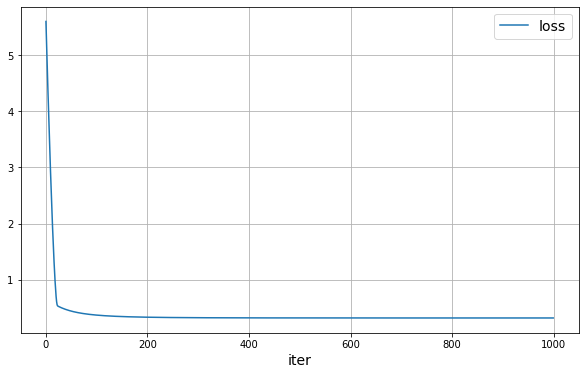

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(losses, label='loss')
plt.legend(fontsize=14)
plt.xlabel('iter', fontsize=14)
plt.grid()

##Задание 3. Accuracy of model on learning data

In [ ]:
from sklearn.metrics import accuracy_score

predictions = clf.predict(X)
score = accuracy_score(y ,predictions)
print(f'Model accuracy = {score}')

Model accuracy = 0.861


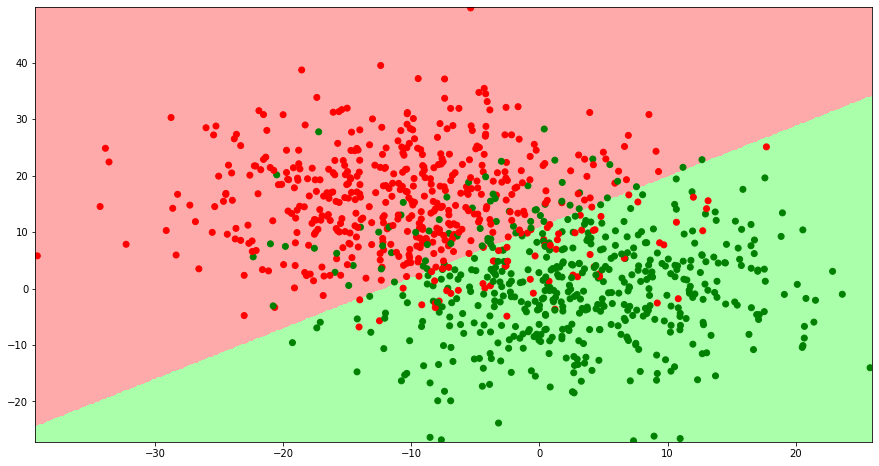

In [ ]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

plt.figure(figsize=(15, 8))

eps = 0.1
xx, yy = np.meshgrid(np.linspace(np.min(X[:, 0]) - eps, np.max(X[:, 0]) + eps, 500), 
                     np.linspace(np.min(X[:, 1]) - eps, np.max(X[:, 1]) + eps, 500))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

plt.scatter(X[:, 0], X[:, 1], c=colored_y)
plt.show()

##Задание 4. Accuracy of model with parametr C = 2 

In [ ]:
#C = 2
clf2 = MyL2LogisticRegression(C=2)
clf2.fit(X, y)

predictions = clf2.predict(X)
score = accuracy_score(y, predictions)
score

0.841

In [ ]:
clf.coef_, clf.intercept_

(array([ 0.15880525, -0.17710981]), 1.928999376474711)

In [ ]:
clf2.coef_, clf2.intercept_

(array([ 0.1681292 , -0.26168282]), 1.324667910291615)

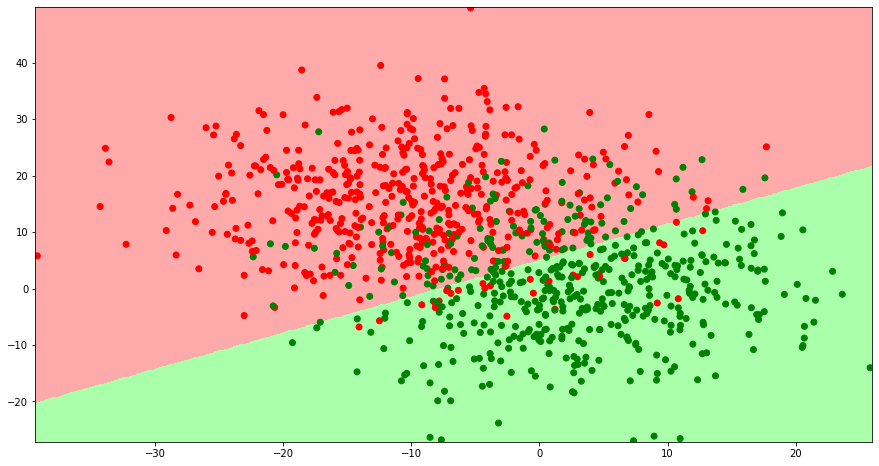

In [ ]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

plt.figure(figsize=(15, 8))

eps = 0.1
xx, yy = np.meshgrid(np.linspace(np.min(X[:, 0]) - eps, np.max(X[:, 0]) + eps, 500), 
                     np.linspace(np.min(X[:, 1]) - eps, np.max(X[:, 1]) + eps, 500))

Z = clf2.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

plt.scatter(X[:, 0], X[:, 1], c=colored_y)
plt.show()

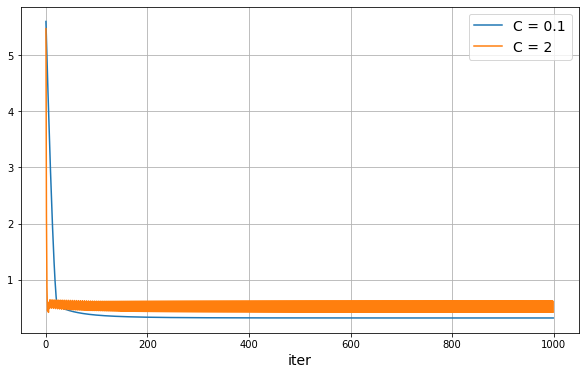

In [ ]:
losses2 = clf2.fit(X, y)
plt.figure(figsize=(10,6))
plt.plot(losses, label='С = 0.1')
plt.plot(losses2, label='C = 2')
plt.legend(fontsize=14)
plt.xlabel('iter', fontsize=14)
plt.grid()

#Чвсть 2. Использование логичстической регрессии из sklearn

In [90]:
!gdown 1T9jXx2qBUMw03BsB2IdZpThDDfKKmrSK
#Скачали forest_dataset.csv

Downloading...
From: https://drive.google.com/uc?id=1T9jXx2qBUMw03BsB2IdZpThDDfKKmrSK
To: /content/forest_dataset.csv
100% 1.29M/1.29M [00:00<00:00, 149MB/s]


In [91]:
all_data = pd.read_csv('forest_dataset.csv')
all_data.head()

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
0,2683,333,35,30,26,2743,121,173,179,6572,...,0,0,0,0,0,0,0,0,0,2
1,2915,90,8,216,11,4433,232,228,129,4019,...,0,0,0,0,0,0,0,0,0,1
2,2941,162,7,698,76,2783,227,242,148,1784,...,0,0,0,0,0,0,0,0,0,2
3,3096,60,17,170,3,3303,231,202,99,5370,...,0,0,0,0,0,0,0,0,0,1
4,2999,66,8,488,37,1532,228,225,131,2290,...,0,0,0,0,0,0,0,0,0,2


In [112]:
#Разобъем данные 
labels = all_data[all_data.columns[-1]].values
feature_matrix = all_data[all_data.columns[:-1]].values

train_feature_matrix, test_feature_matrix, train_labels, test_labels = train_test_split(
    feature_matrix, labels, test_size=0.2, random_state=42)


In [113]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scal_train_feature_matrix = scaler.fit_transform(train_feature_matrix)
scal_test_feature_matrix = scaler.fit_transform(test_feature_matrix)

##Задача 5. Исслаедование регуляризации в slkearn

In [114]:
from sklearn.linear_model import LogisticRegression

C_grid = np.logspace(-5, 5, 11)


train_accuracies = []
test_accuracies = []
for C in C_grid:
    model = LogisticRegression(C=C, max_iter=100)
    model.fit(train_feature_matrix, train_labels)
    train_predictions = model.predict(scal_train_feature_matrix)
    test_predictions = model.predict(scal_test_feature_matrix)
    train_score = accuracy_score(train_labels, train_predictions)
    test_score = accuracy_score(train_labels, train_predictions)
    train_accuracies.append(train_score)
    test_accuracies.append(test_score)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

In [115]:
for i, C in enumerate(C_grid):
    print(C, train_accuracies[i], test_accuracies[i])

1e-05 0.26 0.26
0.0001 0.282125 0.282125
0.001 0.227875 0.227875
0.01 0.23025 0.23025
0.1 0.25 0.25
1.0 0.25775 0.25775
10.0 0.253875 0.253875
100.0 0.252 0.252
1000.0 0.24775 0.24775
10000.0 0.2475 0.2475
100000.0 0.2475 0.2475


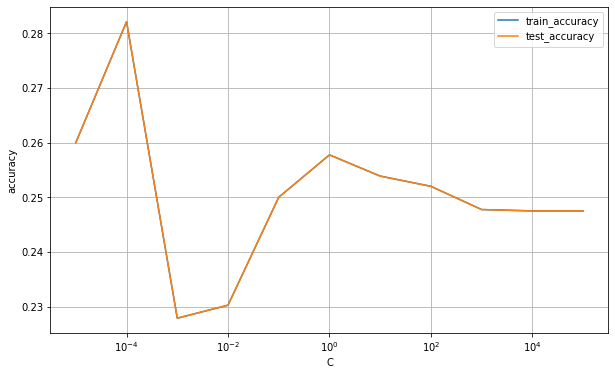

In [116]:
plt.figure(figsize=(10, 6))
plt.plot(C_grid, train_accuracies, label='train_accuracy')
plt.plot(C_grid, test_accuracies, label='test_accuracy')
plt.xlabel('C')
plt.ylabel('accuracy')
plt.xscale('log')
plt.legend()
plt.grid()
plt.show()